## 1. Download Yelp Polarity Review Dataset and Preprocess

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
# !tar -xvzf yelp_review_polarity_csv.tgz


In [3]:
# !cp -r yelp_review_polarity_csv /content/drive/MyDrive/Colab_NoteBooks/Yelp

In [4]:
import pandas as pd

train_data_big = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Yelp/train.csv", header=None, names=["sentiment", "text"])
test_data_big = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Yelp/test.csv", header=None, names=["sentiment", "text"])

In [5]:
def get_smaller_df(df, size):
    data_negative = df[df["sentiment"] == 1].head(size)
    data_postive = df[df["sentiment"] == 2].head(size)
    df_small = pd.concat([data_negative, data_postive])
    return df_small

train_data = get_smaller_df(train_data_big, 7000)
test_data = get_smaller_df(test_data_big, 3000)

1    7000
2    7000
Name: sentiment, dtype: int64
1    3000
2    3000
Name: sentiment, dtype: int64


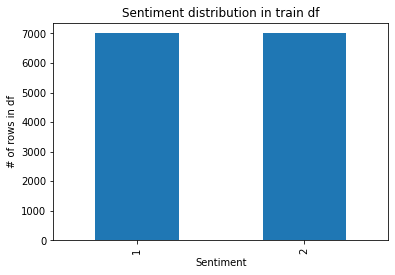

In [6]:
import matplotlib.pyplot as plt

print(train_data["sentiment"].value_counts())
print(test_data["sentiment"].value_counts())

plt.figure()
train_data["sentiment"].value_counts().plot.bar(title="Sentiment distribution in train df")
# pd.value_counts(train_data[0]).plot.bar(title="Sentiment distribution in train df")
plt.xlabel("Sentiment")
plt.ylabel("# of rows in df")
plt.show()

### How to preprocess text data?
* Removal of Stop Words 
* Tokenization
* Stemming

removal of stop words removes necessary words required to get the sentiment and sometimes it can totally change the meaning of the sentence. In the examples printed by above piece of code, it is clear that it can convert a negative statement into positive sentence. Thus, this step is skipped for Sentiment Classification.

In [7]:
from gensim.parsing.preprocessing import remove_stopwords
print(remove_stopwords("I did not like the food!!"))
print(remove_stopwords("This product is not good"))

I like food!!
This product good


Tokenization is the process in which the sentence/text is split into array of words called tokens. This helps to do transformations on each words separately and this is also required to transform words to numbers. There are different ways of performing tokenization.

Here, `simple_preprocess` is used to get the tokens for the dataframe as it does most of the preprocessing already for us. 

In [8]:
from gensim.utils import simple_preprocess

train_data["tokenized_text"] = [simple_preprocess(line, deacc=True) for line in train_data["text"]]
test_data["tokenized_text"] = [simple_preprocess(line, deacc=True) for line in test_data["text"]]

train_data["tokenized_text"].head(5)

0    [unfortunately, the, frustration, of, being, d...
2    [don, know, what, dr, goldberg, was, like, bef...
3    [writing, this, review, to, give, you, heads, ...
5    [wing, sauce, is, like, water, pretty, much, l...
6    [owning, driving, range, inside, the, city, li...
Name: tokenized_text, dtype: object

Stemming process reduces the words to its’ root word. Unlike Lemmatization which uses grammar rules and dictionary for mapping words to root form, stemming **simply removes suffixes/prefixes**. Stemming is widely used in the application of SEOs, Web search results, and information retrieval since as long as the root matches in the text somewhere it helps to retrieve all the related documents in the search.

In [9]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()

train_data["stemmed_tokens"] = [[porter_stemmer.stem(word) for word in tokens] for tokens in train_data["tokenized_text"]]
test_data["stemmed_tokens"] = [[porter_stemmer.stem(word) for word in tokens] for tokens in test_data["tokenized_text"]]

train_data["stemmed_tokens"].head(5)

0    [unfortun, the, frustrat, of, be, dr, goldberg...
2    [don, know, what, dr, goldberg, wa, like, befo...
3    [write, thi, review, to, give, you, head, up, ...
5    [wing, sauc, is, like, water, pretti, much, lo...
6    [own, drive, rang, insid, the, citi, limit, is...
Name: stemmed_tokens, dtype: object

## 2. Train Word2Vec Model and Create Dataloader

In [10]:
from gensim.models import Word2Vec

def make_word2vec_model(train_data, test_data, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if padding:
        temp_train_df = list(pd.Series(train_data['stemmed_tokens']).values)
        temp_test_df = list(pd.Series(test_data['stemmed_tokens']).values)
        temp_df = temp_train_df + temp_test_df
        temp_df.append(['pad'])
        word2vec_file = "/content/drive/MyDrive/Colab_Notebooks/Yelp/" + "models/" + "word2vec_" + str(size) + "_PAD.model"
    else:
        temp_train_df = list(pd.Series(train_data['stemmed_tokens']).values)
        temp_test_df = list(pd.Series(test_data['stemmed_tokens']).values)
        temp_df = temp_train_df + temp_test_df
        word2vec_file = "/content/drive/MyDrive/Colab_Notebooks/Yelp/" + "models/" + "word2vec_" + str(size) + ".model"
    w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)
    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# w2vmodel, word2vec_file = make_word2vec_model(train_data, test_data)

In [11]:
w2vmodel = Word2Vec.load("/content/drive/MyDrive/Colab_Notebooks/Yelp/models/word2vec_500_PAD.model")

In [20]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

MAX_LEN = 950
BATCH_SIZE = 16

cuda


In [13]:
def make_target(label):
    if label == 1:
        return torch.tensor([0], dtype=torch.long, device = device)
    else:
        return torch.tensor([1], dtype=torch.long, device = device)

def make_word2vec_ids(sentence, word2vec, max_len):
    padding_idx = word2vec.wv.key_to_index['pad']
    padded_sentence = [padding_idx for i in range(max_len)]
    i = 0
    for word in sentence:
        if word not in word2vec.wv.key_to_index:
            padded_sentence[i] = 0
        else:
            padded_sentence[i] = word2vec.wv.key_to_index[word]
        i += 1
    return torch.tensor(padded_sentence, dtype=torch.long, device = device)

In [14]:
class YelpReviewDataset(Dataset):
    def __init__(self, reviews, stemmed_tokens, targets, word2vec, max_len):
        super(YelpReviewDataset, self).__init__()
        self.reviews = reviews
        self.stemmed_tokens = stemmed_tokens
        self.targets = targets
        self.max_len = max_len
        self.word2vec = word2vec

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = self.reviews[item]
        tokens = self.stemmed_tokens[item]
        target = make_target(self.targets[item])
        ids = make_word2vec_ids(tokens, self.word2vec, self.max_len)
        return {
            "review": review,
            "ids": ids,
            "target": target
        }

In [21]:
def create_data_loader(df, word2vec, max_len, batch_size):
    ds = YelpReviewDataset(
        reviews = df.text.to_numpy(),
        stemmed_tokens = df.stemmed_tokens.to_numpy(),
        targets = df.sentiment.to_numpy(),
        word2vec = word2vec,
        max_len = max_len
    )

    return DataLoader(ds, batch_size = batch_size, shuffle=True, num_workers=0)

In [22]:
train_data_loader = create_data_loader(train_data, w2vmodel, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, w2vmodel, MAX_LEN, BATCH_SIZE)

In [23]:
sample_data = next(iter(train_data_loader))
print(sample_data["ids"].shape)
print(sample_data["target"].shape)

torch.Size([16, 950])
torch.Size([16, 1])


## 3. Define and Train A TextCNN Model

In [32]:
class CNNConfig(object):
    embedding_dim = 500
    num_filters = 10
    seq_length = 950
    num_classes = 2
    window_sizes = [1, 2, 3, 5]

    dropout_rate = 0.5
    l2_reg = 0.01
    learning_rate = 0.001
    num_epochs = 20

In [33]:
class TextCNN(nn.Module):
    def __init__(self, config, word2vec):
        super(TextCNN, self).__init__()
        self.dropout_rate = config.dropout_rate
        self.num_classes = config.num_classes
        weights = word2vec.wv
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=word2vec.wv.key_to_index['pad'])
        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv1d(in_channels = config.embedding_dim,
                                    out_channels = config.num_filters,
                                    kernel_size = h),
                          nn.ReLU(),
                          nn.MaxPool1d(kernel_size = config.seq_length-h+1)
                          )
            for h in config.window_sizes
        ])
        self.fc = nn.Linear(in_features = config.num_filters*len(config.window_sizes),
                            out_features = config.num_classes)
        
    def forward(self, x):
        # x: (batch_size, seq_length)
        embed_x = self.embedding(x)
        # embed_x: (batch_size, seq_length, embedding_dim)

        embed_x = embed_x.permute(0, 2, 1)
        # embed_x: (batch_size, embedding_dim, seq_length)

        out = [conv(embed_x) for conv in self.convs]
        # out[i]: (batch_size, num_filters, 1)

        out = torch.cat(out, dim = 1)
        # out: (batch_size, num_filters*len(config.window_sizes), 1)

        out = out.view(-1, out.shape[1])
        out = F.dropout(input=out, p = self.dropout_rate)

        logits = self.fc(out)
        # logits: (batch_size, num_classes)

        probs = F.softmax(logits, dim = 1)
        return probs
    

## 3. Train and Eval TextCNN Model

In [34]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_example):
    model = model.train()
    losses = []
    correct_count = 0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for idx, data in progress_bar:
        ids = data["ids"].to(device)
        targets = data["target"].squeeze(dim = 1).to(device)
        probs = model(ids)
        _, preds = torch.max(probs, dim = 1)
        loss = loss_fn(probs, targets)
        correct_count += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.set_description(f"loss:{loss.item():.4f}")

    return correct_count.double() / n_example, np.mean(losses)


In [35]:
config = CNNConfig()
model = TextCNN(config, w2vmodel)
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = config.learning_rate, weight_decay = config.l2_reg)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

loss_file_name = "/content/drive/MyDrive/Colab_Notebooks/Yelp/models/" +  "plots/" + "textcnn_model_500_loss_with_padding.csv"

In [36]:
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')

for epoch in range(config.num_epochs):
    print(f'Epoch {epoch+1}/{config.num_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_function, optimizer, device, len(train_data))
    scheduler.step()
    print('\n')
    print(f'Train loss: {train_loss}  Accuracy: {train_acc}')

    f.write(str(epoch+1) + "," + str(train_loss))
    f.write('\n')

torch.save(model, "/content/drive/MyDrive/Colab_Notebooks/Yelp/models/" + "textcnn_model_500_with_padding.pth")
f.close()

Epoch 1/20
----------


loss:0.6220: 100%|██████████| 875/875 [00:12<00:00, 71.41it/s]




Train loss: 0.5750269333635057  Accuracy: 0.7467857142857144
Epoch 2/20
----------


loss:0.5642: 100%|██████████| 875/875 [00:13<00:00, 65.26it/s]




Train loss: 0.5260813797542027  Accuracy: 0.7991428571428572
Epoch 3/20
----------


loss:0.4771: 100%|██████████| 875/875 [00:12<00:00, 71.48it/s]




Train loss: 0.5179791749886105  Accuracy: 0.8063571428571429
Epoch 4/20
----------


loss:0.4919: 100%|██████████| 875/875 [00:12<00:00, 72.28it/s]




Train loss: 0.517524174962725  Accuracy: 0.8067857142857143
Epoch 5/20
----------


loss:0.4916: 100%|██████████| 875/875 [00:12<00:00, 71.97it/s]




Train loss: 0.5180633298328945  Accuracy: 0.8057142857142858
Epoch 6/20
----------


loss:0.5006: 100%|██████████| 875/875 [00:12<00:00, 71.19it/s]




Train loss: 0.5135533118247986  Accuracy: 0.8097857142857143
Epoch 7/20
----------


loss:0.4729: 100%|██████████| 875/875 [00:12<00:00, 70.42it/s]




Train loss: 0.5163220499243055  Accuracy: 0.8087857142857143
Epoch 8/20
----------


loss:0.5676: 100%|██████████| 875/875 [00:12<00:00, 70.49it/s]




Train loss: 0.5135076575279236  Accuracy: 0.8105714285714286
Epoch 9/20
----------


loss:0.4892: 100%|██████████| 875/875 [00:12<00:00, 70.67it/s]




Train loss: 0.5116733648777008  Accuracy: 0.8113571428571429
Epoch 10/20
----------


loss:0.4399: 100%|██████████| 875/875 [00:12<00:00, 69.94it/s]




Train loss: 0.5132724152292524  Accuracy: 0.8078571428571429
Epoch 11/20
----------


loss:0.5642: 100%|██████████| 875/875 [00:12<00:00, 70.67it/s]




Train loss: 0.4999064608642033  Accuracy: 0.8277857142857143
Epoch 12/20
----------


loss:0.4539: 100%|██████████| 875/875 [00:12<00:00, 69.93it/s]




Train loss: 0.500295489345278  Accuracy: 0.8345714285714286
Epoch 13/20
----------


loss:0.4399: 100%|██████████| 875/875 [00:12<00:00, 69.89it/s]




Train loss: 0.5005350093160357  Accuracy: 0.8310000000000001
Epoch 14/20
----------


loss:0.5209: 100%|██████████| 875/875 [00:12<00:00, 69.66it/s]




Train loss: 0.49966194026810784  Accuracy: 0.8389285714285715
Epoch 15/20
----------


loss:0.4729: 100%|██████████| 875/875 [00:12<00:00, 69.05it/s]




Train loss: 0.49869942709377835  Accuracy: 0.8383571428571429
Epoch 16/20
----------


loss:0.5330: 100%|██████████| 875/875 [00:12<00:00, 68.76it/s]




Train loss: 0.49895087919916425  Accuracy: 0.8356428571428572
Epoch 17/20
----------


loss:0.4764: 100%|██████████| 875/875 [00:12<00:00, 68.85it/s]




Train loss: 0.4966883182866233  Accuracy: 0.8387857142857144
Epoch 18/20
----------


loss:0.4976: 100%|██████████| 875/875 [00:12<00:00, 68.34it/s]




Train loss: 0.4973745288167681  Accuracy: 0.8377142857142857
Epoch 19/20
----------


loss:0.5085: 100%|██████████| 875/875 [00:12<00:00, 69.05it/s]




Train loss: 0.4960676829474313  Accuracy: 0.8403571428571429
Epoch 20/20
----------


loss:0.4012: 100%|██████████| 875/875 [00:12<00:00, 68.90it/s]




Train loss: 0.4962777920109885  Accuracy: 0.8414285714285715


In [37]:
def eval_model(model, data_loader, device):
    model = model.eval()
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    all_targets = []
    all_predictions = []
    for idx, data in progress_bar:
        ids = data["ids"].to(device)
        targets = data["target"].squeeze(dim = 1).to(device)
        probs = model(ids)
        _, preds = torch.max(probs, dim = 1)
        all_targets += targets.cpu().numpy().tolist()
        all_predictions += preds.cpu().numpy().tolist()
    print(classification_report(all_targets, all_predictions))

In [38]:
from sklearn.metrics import classification_report
eval_model(model, test_data_loader, device)

100%|██████████| 375/375 [00:02<00:00, 137.97it/s]

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3000
           1       0.85      0.85      0.85      3000

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



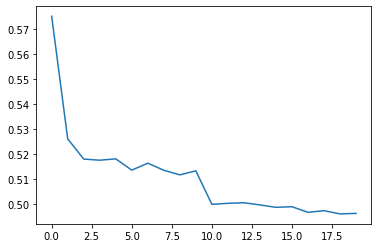

In [39]:
loss_df = pd.read_csv(loss_file_name, header = 0, names = ["iter", "loss"])
pd.to_numeric(loss_df['loss'])
plt_textcnn_model_500_loss_with_padding = loss_df['loss'].plot()